# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - SIMULARE DATI --> Fatto
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist

## Data generation

In [2]:
#Parameter initialization
N = int(1e6)
T = 100
I0 = 50
S0 = N - I0
R0 = 0
beta_true = 0.3
gamma_true = 0.05

betas = 100*[beta_true]
gammas = 100*[gamma_true]

#Simulation
initial_conf = np.array([S0, I0, R0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

In [14]:
delta_I

95

Text(0.5, 1.0, 'Simulated data with varying parameters')

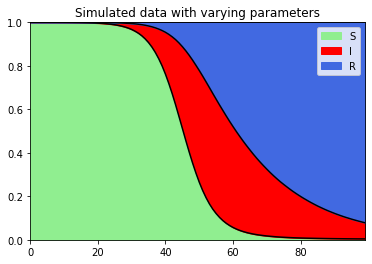

In [3]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

SS = configurations[:, 0]
II = configurations[:, 1]
RR = configurations[:, 2]

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

## MCMC

 - Update delta
 - Update b,r
 - Update gamma

In [4]:
def mylog(x):
    res = np.where(x != 0, np.log(x), -1022)
    return res


### Delta update

In [5]:
def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        total += 2*mylog(gammafunc(0.1 + np.sum(eta == ii)))
        total -= mylog(0.1 + np.sum(beta*(eta==ii)))*(0.1 + np.sum(eta == ii))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(eta==ii)))*(0.1 + np.sum(eta == ii))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif sum_proposed == 1 and sum_now == 2:
        return 3/(T-1)
    elif sum_proposed == T and sum_now == T-1:
        return 3/(T-1)
    elif sum_proposed == 2 and sum_now == 1:
        return (T-1)/3
    elif sum_proposed == T-1 and sum_now == T:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
    print("log_m is: ", log_m)
    
    probability = np.exp(min(0, log_m))
    print("probability is: ", probability)
    
    eps = npr.uniform() 
    if eps < probability:
        print("Accepting")
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    K = np.sum(delta_now).astype(int)
    delta = delta_now.copy()
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now == 1)[0])
        delta[index] -= 1
    else:
        index_0 = npr.choice(np.where(delta_now == 0)[0])
        index_1 = npr.choice(np.where(delta_now == 1)[0])
        delta[index_0] = 1
        delta[index_1] = 0
    
    return delta  

In [6]:
# Try one step
p = .01
T = 100



# Initialize delta
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
# Gamma(paper) takes in shape, scale. npr.gamma takes in shape, rate=1/scale
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

print("GAMMA_0", gamma_0)

delta_1 = propose_delta(delta_0, T)
prova = update_delta(delta_1, delta_0, beta_0, gamma_0, p, T)

delta_1 = prova

GAMMA_0 [0.93001277 0.90646058 0.74079748 0.77933457 0.72410303 0.22692645
 0.25272012 0.68139591 0.64604955 0.71851929 0.23677247 0.24670357
 0.25404043 0.7764035  0.79377894 0.56571795 0.87582893 0.97002337
 0.67165144 0.87194319 0.84353088 0.70866976 0.67881559 0.39375106
 0.64554627 0.15694077 0.70362686 0.34174324 0.42164778 0.77963106
 0.81932767 0.91362435 0.87421813 0.61773007 0.56722326 0.4316838
 0.15101161 0.84852335 0.66545049 0.56825031 0.36662489 0.60356495
 0.64446307 0.30710591 0.21224925 0.37593595 0.71950941 0.36668138
 0.13474009 0.85572118 0.80069954 0.05395025 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

/tmp/ipykernel_30543/3888476496.py:2: RuntimeWarning: divide by zero encountered in log
  res = np.where(x != 0, np.log(x), -1022)


### b and r update

In [7]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next


In [8]:
#Update b, r
eta = np.cumsum(delta_1)

b_1 = update_b(delta_1, beta_0)
b_1 = b_1[eta-1]

r_1 = update_r(delta_1, gamma_0)
r_1 = r_1[eta-1]

/tmp/ipykernel_30543/3888476496.py:2: RuntimeWarning: divide by zero encountered in log
  res = np.where(x != 0, np.log(x), -1022)


### Update beta and gamma

Through some thorough calculations, we find that

$$ y \sim Beta(\Delta I_t + 1, S_{t-1} - \Delta I_t - \frac{b^{(g+1)}_{\eta_t^{(g+1)}}}{P_{t-1}} + 1) $$
then $\beta_t^{(g+1)} = -\frac{log (y)}{P_{t-1}}$

and similarly,

$$ \gamma_t^{(g+1)} \sim Beta(\Delta R_t + r^{(g+1)}_{\eta_t^{(g+1)}}, I_{t-1} - \Delta R_t + 1)$$

In [9]:
def update_beta (SS, S0, delta_I, PP, P0, bb, TT): 

    """
    SS is at time t-1
    PP is at time t-1
    delta_I is at time t
    b is at time t
    """

    new_beta = np.zeros(shape=TT)
    new_beta[0] = -mylog(npr.beta(delta_I[0] + 1, S0 - delta_I[0] - bb[0]/P0 + 1)/P0)
    for tt in range(1,TT):
        new_beta[tt] = -mylog(npr.beta(delta_I[tt] + 1, SS[tt-1] - delta_I[tt] - bb[tt]/PP[tt-1] + 1)/PP[tt-1])

    return new_beta

def update_gamma (delta_R, II, I0, rr, TT):

    """
    II is at time t-1
    delta_R is at time t
    r is at time t
    """

    new_gamma = np.zeros(shape=TT)
    new_gamma[0] = npr.beta(delta_R[0] + rr[0], I0 - delta_R[0] + 1)
    for tt in range(1,TT):
        new_gamma[tt] = npr.beta(delta_R[tt] + rr[tt], II[tt-1] - delta_R[tt] + 1)

    return new_gamma

In [10]:
II/N

array([5.00000e-05, 5.70000e-05, 6.80000e-05, 8.00000e-05, 9.40000e-05,
       1.08000e-04, 1.41000e-04, 1.71000e-04, 2.21000e-04, 2.70000e-04,
       3.28000e-04, 4.02000e-04, 5.07000e-04, 6.35000e-04, 7.87000e-04,
       9.98000e-04, 1.27200e-03, 1.59300e-03, 1.95800e-03, 2.41000e-03,
       3.00800e-03, 3.74500e-03, 4.70500e-03, 5.83500e-03, 7.27300e-03,
       9.11100e-03, 1.13630e-02, 1.42040e-02, 1.75950e-02, 2.18010e-02,
       2.70630e-02, 3.35890e-02, 4.12450e-02, 5.08200e-02, 6.25690e-02,
       7.63990e-02, 9.32260e-02, 1.13064e-01, 1.36101e-01, 1.62415e-01,
       1.92808e-01, 2.26199e-01, 2.61915e-01, 2.99977e-01, 3.38672e-01,
       3.76091e-01, 4.12057e-01, 4.44493e-01, 4.72763e-01, 4.95557e-01,
       5.13831e-01, 5.26101e-01, 5.32737e-01, 5.34691e-01, 5.31973e-01,
       5.25733e-01, 5.16834e-01, 5.06167e-01, 4.93079e-01, 4.78502e-01,
       4.63532e-01, 4.47710e-01, 4.31768e-01, 4.15374e-01, 3.99219e-01,
       3.83079e-01, 3.66846e-01, 3.51128e-01, 3.35831e-01, 3.210

In [11]:
Delta_I =  np.insert(arr = np.array( [II[1:] - II[:-1]]), obj=0, values=II[0]-I0)
Delta_R =  np.insert(arr = np.array( [RR[1:] - RR[:-1]]), obj=0, values=RR[0]-R0)
np.shape(Delta_I)

(100,)

In [12]:
por = np.array([4,5,79,6])
np.insert(por,0,42)

array([42,  4,  5, 79,  6])

In [18]:
delta_I

95

In [21]:
SS[30]

967343.0

In [22]:
for tt in range(1,60):
    print(f'alpha = {Delta_I[tt] + 1}, beta = {SS[tt-1] - Delta_I[tt] - b_1[tt]/(II[tt-1]/N) + 1}\n')

alpha = 8.0, beta = 999780.552481568



In [24]:
Delta_I[50:60]

array([ 18274.,  12270.,   6636.,   1954.,  -2718.,  -6240.,  -8899.,
       -10667., -13088., -14577.])

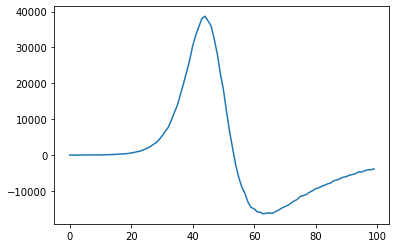

In [23]:
plt.plot(Delta_I)

((array([69., 11.,  6.,  2.,  5.,  2.,  1.,  1.,  1.,  2.]),
  array([9.75910109e-03, 1.02556330e+02, 2.05102900e+02, 3.07649471e+02,
         4.10196042e+02, 5.12742612e+02, 6.15289183e+02, 7.17835754e+02,
         8.20382324e+02, 9.22928895e+02, 1.02547547e+03]),
  <BarContainer object of 10 artists>),
 127.29602173981628)

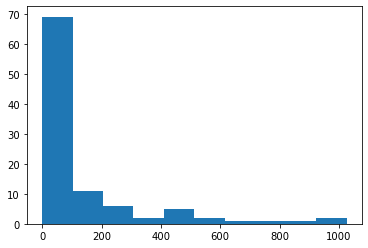

In [27]:
plt.hist(beta_0), np.mean(beta_0)

(array([49.,  3.,  6.,  5.,  3.,  3.,  8.,  7., 10.,  6.]),
 array([0.        , 0.09700234, 0.19400467, 0.29100701, 0.38800935,
        0.48501168, 0.58201402, 0.67901636, 0.77601869, 0.87302103,
        0.97002337]),
 <BarContainer object of 10 artists>)

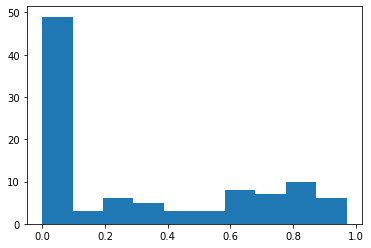

In [29]:
plt.hist(gamma_0)

In [ ]:
def pi_beta(beta_t, P_t_1, Delta_I, S_t_1, pi_beta_given_eta):
    distro = (1-np.exp(-beta_t*P_t_1))**Delta_I * np.exp(-beta_t*P_t_1*(S_t_1-Delta_I))*pi_beta_given_eta
    return distro # / np.sum(distro)

def pi_gamma(gamma_t, Delta_R, I_t_1, pi_gamma_given_r):
    distro = gamma_t**Delta_R *(1-gamma_t)(I_t_1-Delta_R)*pi_gamma_given_r
    return distro # /np.sum(distro)

Nvalues = 10_000

betas = np.linspace(0.1, 10**3, Nvalues)
gammas = np.linspace(0., 1, Nvalues)

# To fix this with the arguments of the functions
missing_arrays = []         

C_beta = np.max(pi_beta(betas, *missing_arrays))
C_gamma = np.max(pi_gamma(gammas, *missing_arrays))

u_1 = np.random.uniform(size=Nvalues)    
u_2 = np.random.uniform(size=Nvalues)    
gamma_sampling = np.random.beta(a=Delta_R+r, b=I-Delta_R+1, size=Nvalues)

mask = u_2 < pi_gamma(gamma_sampling, *missing_arrays)/(C_gamma*gamma_sampling)

ok_values = u_2[mask]

# plotta e vediamo...
plt.plot(gammas, pi_gamma(gammas, *missing_arrays))
plt.scatter(u_2, pi_gamma(u_2, *np.array(missing_arrays)[mask]));

In [13]:
#Update beta, gamma

#beta_1 = update_beta(SS, S0, Delta_I, II/N, I0/N, b_1, T)

#gamma_1 = update_gamma(Delta_R, II, I0, r_1, gamma_0)


ValueError: a <= 0